# College Income Predictor
## *Helping My Sister-in-Law Choose a College and Major With Machine Learning*

## Introduction

As my sister-in-law heads into her senior year of high school, she's beginning to think seriously about where to attend college and what field of study to pursue. Recently, she asked me for advice about which schools I thought that she should consider and which majors might set her up for financial stability after graduation.  

She made it clear that she isn't big on math and science, and prefers something aligned with the liberal arts (i.e., areas like English, history, policital science, psychology, and sociology). She also shared a rough financial goal: ideally earning at least $50,000 within a year of completing her Bachelor's degree. When asked about specific colleges she's considering, she gave me a short list of a few schools that had already caught her interest:
- James Madison University  
- Towson University
- University of Maryland, College Park
- West Virginia University

Given these preferences and goal, I thought it would be interesting to use data-driven tools to help explore which institution-program combinations in her areas of interest might realistically lead to hitting her income goal.  

In this notebook, we build a machine learning pipeline using publicly available data to model post-graduation income outcomes based on historical college program data. Using this model, we make predictions for her schools and programs of interest and identify which combinations are most likely to meet her salary expectations.  

This framework not only provides a personalized recommendation for her but also demonstrates how machine learning can support real-world decision-making in education and career planning.

• Dataset source: [College Scorecard](https://collegescorecard.ed.gov/data/) (U.S. Department of Education)

In [1]:
import pandas as pd
import glob
import os


def load_institution_files(pattern):
    all_files = sorted(glob.glob(pattern))
    data = []
    for f in all_files:
        year = int(os.path.basename(f).split('_')[0].replace('MERGED', ''))
        df = pd.read_csv(f, low_memory=False)
        df['DATA_YEAR'] = year
        data.append(df)
    return pd.concat(data, ignore_index=True)


def load_field_files(pattern):
    all_files = sorted(glob.glob(pattern))
    data = []
    for f in all_files:
        # Extract year range string like '1415' from filename
        basename = os.path.basename(f)
        year_token = basename.replace('FieldOfStudyData', '').split('_')[0]
        year_suffix = int(year_token[-2:])  # Use the LAST 2 digits and assume 2000s
        year = 2000 + year_suffix
       
        df = pd.read_csv(f, low_memory=False)
        df['DATA_YEAR'] = year
        data.append(df)
    return pd.concat(data, ignore_index=True)


# Config inputs
SAVE_DATA = True
BASE_DIR = './College_Scorecard_Raw_Data_05192025'
INSTITUTION_PATH_PATTERN = os.path.join(BASE_DIR, 'MERGED*_PP.csv')
FIELD_PATH_PATTERN = os.path.join(BASE_DIR, 'FieldOfStudyData*_PP.csv')

# Problem inputs
ML_TARGET = 'ABOVE_TARGET'  # Label for ML model
TARGET_INCOME = 50000  # Fix target income based on desired income
SEED = 42  # Fix seed for randomness
K_FOLD = 5

# Load data
institution_df = load_institution_files(INSTITUTION_PATH_PATTERN)
field_df = load_field_files(FIELD_PATH_PATTERN)
print('Data loaded.')

Data loaded.


## Data Preparation and Cleaning

We will have to prepare and clean two separate datasets before combining: one for institution-level data and one for field of study-level data.

In [2]:
def summarize_dataframe(df, name='DataFrame'):
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'num_missing': df.isna().sum(),
        'pct_missing': df.isna().mean(),
        'num_unique': df.nunique(),
        'sample_values': df.apply(lambda col: col.dropna().unique()[:5])
    })
    summary = summary.sort_values(by='pct_missing', ascending=False)

    print(f'\nSummary of {name}:')
    print(f'• Shape: {df.shape}')
    print(f'• Total columns: {df.shape[1]}')
    print(f'• Columns with >50% missing: {(summary.pct_missing > 0.5).sum()}')
    print(f'• Object columns likely not numeric: {(summary["dtype"] == "object").sum()}')

    return summary

### Institution Data

Let us trim the dataset to variables that are known at the time of admission.

In [3]:
# Trim dataset to variables that are known at time of admission
institution_cols = [
    'DATA_YEAR', 'UNITID', 'CONTROL', 'REGION', 'LOCALE', 'MAIN', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL',
    'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'COSTT4_A', 'PCTPELL',
    'NPT4_PUB', 'NPT4_PRIV',
    'ADM_RATE', 'SAT_AVG', 'UGDS', 'AVGFACSAL',
    'RET_FT4', 'C150_4', 'GRAD_DEBT_MDN_SUPP'
]
institution_df_sub = institution_df[institution_cols].copy()

# Summarize institution DataFrame
summarize_dataframe(institution_df_sub, name='Institution DataFrame')


Summary of Institution DataFrame:
• Shape: (196163, 23)
• Total columns: 23
• Columns with >50% missing: 13
• Object columns likely not numeric: 1


,dtype,num_missing,pct_missing,num_unique,sample_values
LOCALE,float64,190239,0.969801,13,"[12.0, 32.0, 31.0, 13.0, 21.0]"
HBCU,float64,190239,0.969801,2,"[1.0, 0.0]"
PBI,float64,190239,0.969801,2,"[0.0, 1.0]"
ANNHI,float64,190239,0.969801,2,"[0.0, 1.0]"
TRIBAL,float64,190239,0.969801,2,"[0.0, 1.0]"
NPT4_PUB,float64,168372,0.858327,14127,"[7966.0, 12399.0, 10044.0, 8904.0, 15952.0]"
SAT_AVG,float64,165288,0.842605,846,"[970.0, 1030.0, 1109.0, 784.0, 1091.0]"
RET_FT4,float64,151700,0.773336,5863,"[0.64, 0.77, 0.0, 0.76, 0.56]"
ADM_RATE,float64,141440,0.721033,8514,"[0.7505, 0.9098, 0.8381, 0.7948, 0.7594]"
COSTT4_A,float64,140448,0.715976,30853,"[13242.0, 16955.0, 20100.0, 16876.0, 14000.0]"


#### Standardize All Null Values

Having variations of null values within a data set can lead to a lower-performing model. To avoid this factor, let us replace all custom null values with np.nan across the entire DataFrame. From the data dictionary and data.yaml available, null values include: 
- 'NULL'
- PrivacySuppressed
- NA
- PS

We can see PS in the sample values of the `GRAD_DEBT_MDN_SUPP` data in the table above.

In [4]:
import numpy as np


def standardize_nulls(df, null_values):
    df.replace(null_values, np.nan, inplace=True)
    return df.infer_objects(copy=False)


# Standardize all null values
CUSTOM_NULLS = ['NULL', 'PrivacySuppressed', 'NA', 'PS']
institution_df_sub = standardize_nulls(institution_df_sub, CUSTOM_NULLS)

# Drop columns that are all N/A
institution_df_sub.drop(columns=institution_df_sub.columns[institution_df_sub.isna().all()], inplace=True)

#### Convert to Proper Data Types

Let us now convert the columns to proper data types. For example, numerical values are assumed to have an order while categorical treats numeric values as labels, not values. Some of the data type conversions to do are:  
1. GRAD_DEBT_MDN_SUPP should be numeric instead of object.
2. Columns like 'HBCU', 'PBI', and 'TRIBAL' are boolean instead of float64.
3. Columns like 'LOCALE' and 'REGION' are categorical instead of float64.
4. Columns like 'CONTROL' are integer, but have NaN instead of float64.

In [5]:
# Convert to numeric columns
institution_df_sub['GRAD_DEBT_MDN_SUPP'] = pd.to_numeric(
    institution_df_sub['GRAD_DEBT_MDN_SUPP'].replace(CUSTOM_NULLS, np.nan),
    errors='coerce',
)

# Convert to nullable boolean dtype
bool_cols = ['HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'MAIN']
for col in bool_cols:
    institution_df_sub[col] = institution_df_sub[col].astype('boolean')

# Convert categorical numeric codes
cat_cols = ['LOCALE', 'REGION']
for col in cat_cols:
    institution_df_sub[col] = institution_df_sub[col].astype('category')

# Convert to numeric columns, all
institution_df_sub['CONTROL'] = institution_df_sub['CONTROL'].astype('Int8')

# Summarize institution DataFrame
summarize_dataframe(institution_df_sub, name='institution-level data')


Summary of institution-level data:
• Shape: (196163, 23)
• Total columns: 23
• Columns with >50% missing: 13
• Object columns likely not numeric: 0


,dtype,num_missing,pct_missing,num_unique,sample_values
LOCALE,category,190239,0.969801,13,"[12.0, 32.0, 31.0, 13.0, 21.0] Categories (13,..."
HBCU,boolean,190239,0.969801,2,"[True, False]"
PBI,boolean,190239,0.969801,2,"[False, True]"
ANNHI,boolean,190239,0.969801,2,"[False, True]"
TRIBAL,boolean,190239,0.969801,2,"[False, True]"
NPT4_PUB,float64,168372,0.858327,14127,"[7966.0, 12399.0, 10044.0, 8904.0, 15952.0]"
SAT_AVG,float64,165288,0.842605,846,"[970.0, 1030.0, 1109.0, 784.0, 1091.0]"
RET_FT4,float64,151700,0.773336,5863,"[0.64, 0.77, 0.0, 0.76, 0.56]"
ADM_RATE,float64,141440,0.721033,8514,"[0.7505, 0.9098, 0.8381, 0.7948, 0.7594]"
COSTT4_A,float64,140448,0.715976,30853,"[13242.0, 16955.0, 20100.0, 16876.0, 14000.0]"


### Field of Study Data

#### Data Target Definition

Let us determine the best target column from the initial field of study dataset. Let us examine all columns related to earning considering all graduates, or any special demographics that are known. For the example of my sister-in-law, we will exclude conditional columns such as graduates who receive a Pell Grant or are male and will focus on income one year after graduation. The prefixes corresponding to these columns are:  
- `EARN_MDN`
- `EARN_NE`
- `EARN_NOPELL`
- `EARN_NOMALE`
  
As these are newly-examined columns, we will have to standardize the null values again.

In [6]:
# Potential target columns using relevant prefixes considering 1 year after graduation
prefixes = ('EARN_MDN', 'EARN_NE', 'EARN_NOPELL', 'EARN_NOMALE')
potential_target_cols = [col for col in field_df.columns if col.startswith(prefixes) and col.endswith('_1YR')]
target_df = field_df[potential_target_cols].copy()

# Standardize all null values
CUSTOM_NULLS = ['NULL', 'PrivacySuppressed', 'NA', 'PS']
target_df = standardize_nulls(target_df, CUSTOM_NULLS)

# Create a summary of the number of missing and unique values in the potential columns
summary = pd.DataFrame({
    'dtype': target_df.dtypes,
    'num_missing': target_df.isna().sum(),
    'pct_missing': target_df.isna().mean(),
    'num_unique': target_df.nunique(),
})
summary = summary.sort_values(by='num_missing', ascending=True)
print(summary)

                          dtype  num_missing  pct_missing  num_unique
EARN_MDN_HI_1YR          object      1222976     0.879347       37624
EARN_MDN_1YR             object      1285466     0.924278       52387
EARN_NOMALE_WNE_MDN_1YR  object      1299389     0.934289       45308
EARN_NOPELL_WNE_MDN_1YR  object      1322758     0.951092       39626


Based on the amount of available samples (i.e., lowest number/percent missing), let us select the target from the dataset to be `EARN_MDN_HI_1YR` corresponding to median earnings of graduates working and not enrolled 1 year after completing highest credential. This variable lends itself to consider varying level of credential (e.g. Bachelor's versus Master's degree earners).

In [7]:
DATA_TARGET = 'EARN_MDN_HI_1YR'

#### Dataset Preparation

Prepare the field of study dataset in a similar fashion as the institution level data.

In [8]:
# Keep only columns that are known at time of enrollment
FIELD_COLS = [
    'UNITID',
    'CONTROL',
    'MAIN',
    'CIPCODE',
    'CREDLEV',
    'DATA_YEAR',
]
FIELD_COLS += [DATA_TARGET]
field_df_sub = field_df[FIELD_COLS].copy()

In [9]:
# Initial summary of DataFrame
summarize_dataframe(field_df_sub, 'field of study-level data')


Summary of field of study-level data:
• Shape: (1390778, 7)
• Total columns: 7
• Columns with >50% missing: 0
• Object columns likely not numeric: 2


,dtype,num_missing,pct_missing,num_unique,sample_values
EARN_MDN_HI_1YR,object,681965,0.490348,37625,"[PS, 54300, 25400, 54500, 45800]"
UNITID,float64,51083,0.036730,8003,"[100654.0, 100663.0, 100690.0, 100706.0, 10072..."
CONTROL,object,0,0.000000,4,"[Public, Private, nonprofit, Private, for-prof..."
MAIN,int64,0,0.000000,2,"[1, 0]"
CIPCODE,int64,0,0.000000,447,"[100, 101, 109, 110, 111]"
CREDLEV,int64,0,0.000000,8,"[3, 5, 6, 8, 7]"
DATA_YEAR,int64,0,0.000000,6,"[2015, 2016, 2017, 2018, 2019]"


#### Standardize All Null Values

Let us standardize the DataFrame for all null values as with the institution level data.

In [10]:
# Standardize all null values
field_df_sub = standardize_nulls(field_df_sub, CUSTOM_NULLS)

# Drop columns that are all N/A
field_df_sub.drop(columns=field_df_sub.columns[field_df_sub.isna().all()], inplace=True)

#### Convert to Proper Data Types

In [11]:
# Convert to numeric columns
field_df_sub[DATA_TARGET] = pd.to_numeric(field_df_sub[DATA_TARGET], errors='coerce').astype('float64')
field_df_sub['UNITID'] = pd.to_numeric(field_df_sub['UNITID'], errors='coerce').astype('Int64')

# Convert to nullable boolean dtype
bool_cols = ['MAIN']
for col in bool_cols:
    field_df_sub[col] = field_df_sub[col].astype('boolean')

# Map CONTROL from string to integer
control_map = {
    'Public': 1,
    'Private, nonprofit': 2,
    'Private, for-profit': 3,
    'Foreign': 4
}
pd.set_option('future.no_silent_downcasting', True)  # Set future behavior for safety
field_df_sub['CONTROL'] = field_df_sub['CONTROL'].replace(control_map).astype('Int8')

# CREDLEV, while numeric, aren't evenlt spaced or orginal intervals --> category
field_df_sub["CREDLEV"] = field_df_sub["CREDLEV"].astype("category")
field_df_sub = pd.get_dummies(field_df_sub, columns=["CREDLEV"], drop_first=True)

# Summarize final DataFrame
summarize_dataframe(field_df_sub, name='Field of Study DataFrame')


Summary of Field of Study DataFrame:
• Shape: (1390778, 13)
• Total columns: 13
• Columns with >50% missing: 1
• Object columns likely not numeric: 0


,dtype,num_missing,pct_missing,num_unique,sample_values
EARN_MDN_HI_1YR,float64,1222976,0.879347,37624,"[54300.0, 25400.0, 54500.0, 45800.0, 24000.0]"
UNITID,Int64,51083,0.036730,8003,"[100654, 100663, 100690, 100706, 100724]"
CONTROL,Int8,0,0.000000,4,"[1, 2, 3, 4]"
CIPCODE,int64,0,0.000000,447,"[100, 101, 109, 110, 111]"
MAIN,boolean,0,0.000000,2,"[True, False]"
DATA_YEAR,int64,0,0.000000,6,"[2015, 2016, 2017, 2018, 2019]"
CREDLEV_2,bool,0,0.000000,2,"[False, True]"
CREDLEV_3,bool,0,0.000000,2,"[True, False]"
CREDLEV_4,bool,0,0.000000,2,"[False, True]"
CREDLEV_5,bool,0,0.000000,2,"[False, True]"


## Median Earnings Prediction via Machine Learning

In [12]:
# Let us initialize both DataFrames for our model
institution_df_ml = institution_df_sub.copy()
field_df_ml = field_df_sub.copy()

Let us compare the data types of shared columns to ensure consistency.

In [13]:
def compare_shared_columns(df1, df2, name1='df1', name2='df2'):
    shared_cols = list(set(df1.columns) & set(df2.columns))

    comparison = pd.DataFrame({
        'column': shared_cols,
        f'{name1}_dtype': [df1[col].dtype for col in shared_cols],
        f'{name2}_dtype': [df2[col].dtype for col in shared_cols],
        'same_dtype': [df1[col].dtype == df2[col].dtype for col in shared_cols]
    }).sort_values('column')

    return comparison


# Determine shared columns
shared_cols = list(set(field_df_ml.columns) & set(institution_df_sub.columns))
print(shared_cols)

# Compare shared columns
compare_df = compare_shared_columns(field_df_ml, institution_df_ml, 'field', 'institution')
print(compare_df)

['CONTROL', 'UNITID', 'DATA_YEAR', 'MAIN']
      column field_dtype institution_dtype  same_dtype
0    CONTROL        Int8              Int8        True
2  DATA_YEAR       int64             int64        True
3       MAIN     boolean           boolean        True
1     UNITID       Int64             int64       False


There are four columns shared between the two datasets; however, the `UNITIT` column has inconsistent data types. Let us set `UNITIT` to Int64 in both DataFrames and then compare the shared column data types again.

In [14]:
institution_df_ml['UNITID'] = institution_df_ml['UNITID'].astype('Int64')

# Compare again
compare_df = compare_shared_columns(field_df_ml, institution_df_ml, 'field', 'institution')
print(compare_df)

      column field_dtype institution_dtype  same_dtype
0    CONTROL        Int8              Int8        True
2  DATA_YEAR       int64             int64        True
3       MAIN     boolean           boolean        True
1     UNITID       Int64             Int64        True


Great! Now let us merge the two DataFrames together based on the `UNITID` and `DATA_YEAR`.

In [15]:
# Join field and institution using UNITID and year
df = field_df_ml.merge(institution_df_ml, on=['UNITID', 'DATA_YEAR'], how='left', suffixes=('_field', '_inst'))

Since we merged on `UNITID` and `DATA_YEAR`, let's compare the other two shared columns: `CONTROL` and `MAIN` and see if there are any mismatched rows. Additionally, let us check for rows where there was no match in the institution data by directly checking for missing values in the columns coming from institution_df_ml, like `MAIN_inst` and `CONTROL_inst`.

In [16]:
# Determine rows with a mismatch in the (1) MAIN and (2) CONTROL variables and (3) no institution match
mismatched_main = df[df['MAIN_field'] != df['MAIN_inst']]
mismatched_control = df[df['CONTROL_field'] != df['CONTROL_inst']]
missing_institution_info = df[df['MAIN_inst'].isna() & df['CONTROL_inst'].isna()]

print('Mismatches in MAIN:\n', mismatched_main[['MAIN_field', 'MAIN_inst']].head())
print('\nMismatches in CONTROL:\n', mismatched_control[['CONTROL_field', 'CONTROL_inst']].head())
print('\nMissing institution data:\n', missing_institution_info[['MAIN_field', 'MAIN_inst', 'CONTROL_field', 'CONTROL_inst', DATA_TARGET]].head())

Mismatches in MAIN:
        MAIN_field  MAIN_inst
4488        False       True
54029       False       True
74763       False       True
81686       False       True
96114       False       True

Mismatches in CONTROL:
        CONTROL_field  CONTROL_inst
72939              1             2
72940              1             2
72941              1             2
72942              1             2
72943              1             2

Missing institution data:
       MAIN_field  MAIN_inst  CONTROL_field  CONTROL_inst  EARN_MDN_HI_1YR
3104        True       <NA>              3          <NA>              NaN
3105        True       <NA>              3          <NA>              NaN
3106        True       <NA>              3          <NA>              NaN
3107        True       <NA>              3          <NA>              NaN
3108        True       <NA>              3          <NA>              NaN


It appears there are some samples with discrepancies regarding `MAIN` (the flag for main campus) and `CONTROL` (the level of control of institution, where 1, 2, 3, and 4 correspond to public, preivate nonprofit, private for-profit, and foreign, respectively). I was able to confirm that 1) the labels for 1-4 are consistent across the institution data and field of study data and 2) the samples are inconsistently labeled.  For example, the denotation of public versus private institution was not consistent between the datasets. Additionally, there are some rows with field of study data but no corresponding institution data.

For now, rather than manually verifying the inconsistencies, we will drop all rows with these inconsistencies.

In [17]:
# Determine mismatches where both sides are non-null and values differ
mask_main = (
    df['MAIN_field'].notna() &
    df['MAIN_inst'].notna() &
    (df['MAIN_field'] != df['MAIN_inst'])
)

mask_control = (
    df['CONTROL_field'].notna() &
    df['CONTROL_inst'].notna() &
    (df['CONTROL_field'] != df['CONTROL_inst'])
)

# Determine rows with no institutional info at all
mask_missing = df['MAIN_inst'].isna() & df['CONTROL_inst'].isna()

# Combine all exclusion masks and keep only valid rows
mask = mask_main | mask_control | mask_missing
df_clean = df[~mask]  # Keep only valid rows
print(f'Original: {len(df)}, Cleaned: {len(df_clean)}, Dropped: {len(df) - len(df_clean)}')

Original: 1390778, Cleaned: 1316028, Dropped: 74750


Now that the remaining rows have the same values for `CONTROL` and `MAIN` from both datasets, let's drop the columns corresponding to the institution and rename for simplicity downstream. Then we can drop any constant (i.e., zero variance) columns and definte the binary machine learning target and we will be ready to go!

In [18]:
# Drop the _inst version (keeping _field)
cols_to_drop = ['CONTROL_inst', 'MAIN_inst']
for col in cols_to_drop:
    if col in df_clean:
        df_clean = df_clean.drop(columns=col)

# Rename _field version to remove suffix
df_clean.rename(columns={
    'CONTROL_field': 'CONTROL',
    'MAIN_field': 'MAIN'
}, inplace=True)

# Drop constant (zero variance) columns
nunique = df_clean.nunique()
low_variance_cols = nunique[nunique <= 1].index.tolist()
df_clean = df_clean.drop(columns=low_variance_cols)
print(f'Columns with zero variance (constant) that were dropped: {low_variance_cols}.')

# Handle missing/invalid targets
df_clean[DATA_TARGET] = pd.to_numeric(df_clean[DATA_TARGET], errors='coerce')
df_clean = df_clean.dropna(subset=[DATA_TARGET])

# Define binary target
df_clean[ML_TARGET] = (df_clean[DATA_TARGET] >= TARGET_INCOME).astype(int)

# Export clean training data, if desired
if SAVE_DATA:
    df_clean.to_csv('program_risk_model_dataset.csv', index=False)

Columns with zero variance (constant) that were dropped: ['LOCALE', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL'].


First, let us create a binary target based on whether or not the target from the dataset is above the target income 1 year after graduation.  

Next, let us choose an evaluation metric. Choosing evaluation metrics depends entirely on the goals of the model, the nature of the problem, and how the predictions will be used.  

Let us explore the context:  
1. Which class is more important?
  - Is it more costly to miss a program which would result in an above-target income (*false negative*)
  - Or is it worse to flag a program which would result in below-target income as above-target (*false positive*)

2. Are the classes imbalanced?
  - If one class occurs much more often, accuracy may be misleading.

In [19]:
# Count and percentage of each class
print('Class counts:\n', df_clean[ML_TARGET].value_counts())
print('\nClass distribution (%):\n', df_clean[ML_TARGET].value_counts(normalize=True) * 100)

Class counts:
 ABOVE_TARGET
0    118265
1     44270
Name: count, dtype: int64

Class distribution (%):
 ABOVE_TARGET
0    72.76279
1    27.23721
Name: proportion, dtype: float64


Assuming that it is more costly to flag a program which would result in below-target income as above-target (*false positive*) than to simply miss a program which would result in an above-target income (*false negative*) and the classes are moderately imbalanced, we want to:
  - Optimize for precision (class 1)
  - Use precision recall (PR) curves during threshold tuning
  - Avoid evaluating only accuracy as is it misleading under imbalance, which occurs in our dataset.

### Data Preparation

In [20]:
from sklearn.model_selection import StratifiedKFold


# Drop identifier/duplicated/unnecessary columns
drop_cols = ['INSTNM', 'OPEID6', 'DATA_YEAR', 'PCTPELL', 'GRAD_DEBT_MDN_SUPP']
drop_cols += [DATA_TARGET, ML_TARGET]

# Setup stratified k-fold
cv = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

### Baseline Model

If we are to meaningfully evaluate our model, it is essential to compare it against a baseline classifier; a simple model that makes predictions without learning from the data. This helps to ensure that our model adds real predictive value beyond naive heuristics. A couple of options we have are:  
1. A majority class baseline which always predicts the most frequent class (Below Target in our case)
2. A stratified baseline which randomly predicts classes based on their frequency in the dataset.

Let us incorporate both.


#### Majority Class Baseline

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score, classification_report, precision_score
from sklearn.model_selection import cross_val_predict


# Train baseline model using majority class strategy
baseline_clf = DummyClassifier(strategy='most_frequent')

# Split features and label
X = df_clean.drop(columns=drop_cols, errors='ignore')
y = df_clean[ML_TARGET]

# Predict labels and probabilities via CV
y_baseline_pred = cross_val_predict(baseline_clf, X, y, cv=cv, method='predict')
y_baseline_proba = cross_val_predict(baseline_clf, X, y, cv=cv, method='predict_proba')[:, 1]

# Report and metrics
print('\n=== Baseline (Most Frequent Class) Report - Cross-Validated ===')
print(classification_report(y, y_baseline_pred, target_names=['Below Target', 'Above Target'], zero_division=0))

baseline_precision = precision_score(y, y_baseline_pred, pos_label=1, zero_division=0)
baseline_avg_precision = average_precision_score(y, y_baseline_proba)

print(f'Baseline Precision (Above Target): {baseline_precision:.3f}')
print(f'Baseline Average Precision Score (PR AUC): {baseline_avg_precision:.3f}')


=== Baseline (Most Frequent Class) Report - Cross-Validated ===
              precision    recall  f1-score   support

Below Target       0.73      1.00      0.84    118265
Above Target       0.00      0.00      0.00     44270

    accuracy                           0.73    162535
   macro avg       0.36      0.50      0.42    162535
weighted avg       0.53      0.73      0.61    162535

Baseline Precision (Above Target): 0.000
Baseline Average Precision Score (PR AUC): 0.272


In [22]:
# Stratified baseline (random predictions respecting class distribution)
stratified_clf = DummyClassifier(strategy='stratified', random_state=SEED)

# Predict labels and probabilities via CV
y_pred_stratified_bl = cross_val_predict(stratified_clf, X, y, cv=cv, method='predict')
y_proba_stratified_bl = cross_val_predict(stratified_clf, X, y, cv=cv, method='predict_proba')[:, 1]

# Report and metrics
print('\n=== Baseline (Stratified) Report - Cross-Validated ===')
print(classification_report(y, y_pred_stratified_bl, target_names=['Below Target', 'Above Target'], zero_division=0))

stratified_baseline_precision = precision_score(y, y_pred_stratified_bl, pos_label=1, zero_division=0)
stratified_baseline_avg_precision = average_precision_score(y, y_proba_stratified_bl)

print(f'Baseline (Stratified) Precision (Above Target): {stratified_baseline_precision:.3f}')
print(f'Baseline (Stratified) Average Precision Score (PR AUC): {stratified_baseline_avg_precision:.3f}')


=== Baseline (Stratified) Report - Cross-Validated ===
              precision    recall  f1-score   support

Below Target       0.73      0.73      0.73    118265
Above Target       0.27      0.27      0.27     44270

    accuracy                           0.61    162535
   macro avg       0.50      0.50      0.50    162535
weighted avg       0.60      0.61      0.61    162535

Baseline (Stratified) Precision (Above Target): 0.274
Baseline (Stratified) Average Precision Score (PR AUC): 0.273


This highlights a crucial insight when interpreting baselines under class imbalance and a precision-focused objective. Our class of interest (above target) is the minority, and therefore adopting a majority class baseline will always predict class 0 (below target), never predicting class 1. This results in $TP$ = $FP$ = 0.  Therefore, when  
$$
\text{Precision} = \frac{TP}{TP + FP} = 0
$$
the majority class baseline is not useful for our goal of identifying high-income programs. As we care about precision (minimizing false positives), then the stratified baseline becomes a more honest reference point than most frequent and our model should significantly beat 27% precision (class 1) to be considered useful. PR AUC is good for prioritizing precision and recall, especially for the minority class. As class 1 *is* rare and precision matters, this is a potential additional metric to consider.

### Model Preparation

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


def evaluate_model_with_cv(
    df, 
    label_col, 
    drop_cols=None, 
    model=None, 
    cv=None, 
    seed=42,
    target_names=['Below Target', 'Above Target'],
    threshold=0.5,
):

    if drop_cols is None:
        drop_cols = []
    if model is None:
        raise ValueError('No model specified.')
    
    # Split features and target
    X = df.drop(columns=drop_cols + [label_col], errors='ignore')
    y = df[label_col]
    
    # Identify numeric columns (excluding encoded categoricals)
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Define preprocessor
    preprocessor = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_cols)],
        remainder='passthrough'
    )

    # Build pipeline
    clf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    
    # Cross-validated predictions
    y_proba = cross_val_predict(clf_pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
    y_pred = (y_proba >= threshold).astype(int)  # Apply threshold manually
    
    # Evaluation
    print('=== Classification Report (Cross-Validated) ===')
    print(classification_report(y, y_pred, target_names=target_names))
    
    precision = precision_score(y, y_pred, pos_label=1, zero_division=0)
    avg_precision = average_precision_score(y, y_proba)
    roc_auc = roc_auc_score(y, y_proba)
    
    print(f'Precision (Above Target): {precision:.3f}')
    print(f'Average Precision Score (PR AUC): {avg_precision:.3f}')
    print(f'Area Under the ROC Curve (ROC AUC): {roc_auc:.3f}')

    return clf_pipeline, y_pred, y_proba

We will use a **Random Forest Classifier** because it provides a strong balance between predictive performance and interpretability, especially on structured tabular data like ours. Random forests handle both numerical and categorical features well, are robust to outliers and missing data, and naturally capture nonlinear relationships and interactions without extensive preprocessing. 

In [24]:
from sklearn.ensemble import RandomForestClassifier


# Create a base RF model for downstream use
BASE_RF = RandomForestClassifier(n_estimators=100, random_state=SEED)

# Evaluate baseline RF model using cross validation
_, _, y_proba_baseline_rf = evaluate_model_with_cv(
    df=df_clean, 
    label_col=ML_TARGET, 
    drop_cols=drop_cols, 
    model=BASE_RF, 
    cv=cv, 
    seed=SEED,
)

=== Classification Report (Cross-Validated) ===
              precision    recall  f1-score   support

Below Target       0.92      0.93      0.92    118265
Above Target       0.80      0.77      0.79     44270

    accuracy                           0.89    162535
   macro avg       0.86      0.85      0.85    162535
weighted avg       0.88      0.89      0.89    162535

Precision (Above Target): 0.802
Average Precision Score (PR AUC): 0.880
Area Under the ROC Curve (ROC AUC): 0.946


Let us interpret these results in the context of our original goal: maximizing **precision** for the minority class ('Above Target') while minimizing false positives. We focus on key metrics such as precision and recall for class 1, average precision (PR AUC), macro-averaged F1, and the support for our target class.

### Key Metrics Summary

| Metric                     | Value  | Interpretation                                                                 |
|----------------------------|--------|--------------------------------------------------------------------------------|
| Precision (Above Target)   | 0.802  | 80.2% of predicted "Above Target" programs are correct - low false positive rate |
| Recall (Above Target)      | 0.77   | Captures 77% of actual "Above Target" programs - solid coverage               |
| Average Precision (PR AUC) | 0.880  | Excellent ranking performance - much better than stratified baseline (0.274)             |
| Macro Avg F1               | 0.85   | Indicates balanced performance across classes                                                    |
| Support (class 1)          | 44,270 | Plenty of positive examples for robust evaluation                             |

To evaluate the model's ability to distinguish between high- and low-performing programs across all classification thresholds, we examine the Receiver Operating Characteristic (ROC) curve. This curve shows the tradeoff between the true positive rate (recall or sensitivity) and the false positive rate as the decision threshold varies. A model with strong discriminative ability will curve sharply toward the top-left corner, indicating high recall with few false positives. For context, we include both the stratified random baseline and a diagonal line representing random guessing.

While our primary goal is to maximize **precision** for the minority class ('Above Target'), thus minimizing false positives, the ROC curve and its associated Area Under the ROC Curve (AUC) still provide value. A high ROC AUC indicates that the model **ranks** 'Above Target' programs consistently higher than 'Below Target' ones, which is important when threshold tuning.  In our case, the ROC curve confirms that the model achieves strong class separation, giving us flexibility to set thresholds that align with our precision goals.

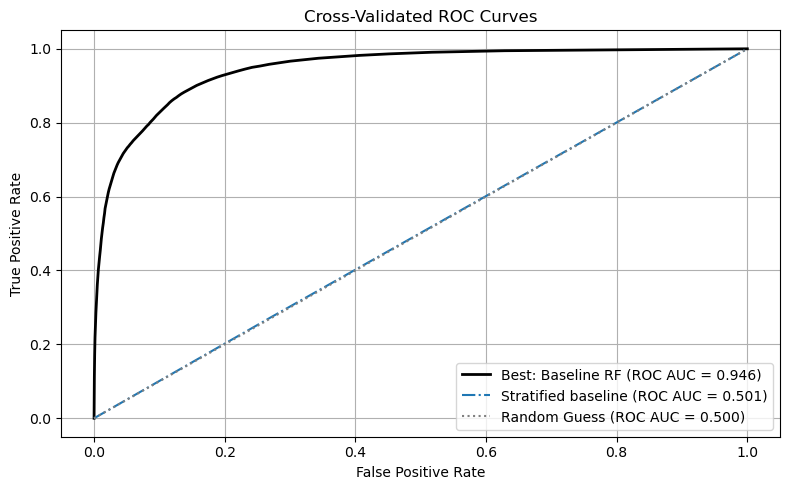

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


def create_roc_curves(y, model_probs, save_figure=False, save_name='roc_curves.png'):
    
    # ROC curve and AUC for trained model and baselines
    roc_info = []
    for name, prob in model_probs.items():
        if name == 'Stratified baseline':
            ls = '-.'
        else:
            ls = '--'
        fpr, tpr, _ = roc_curve(y, prob)
        roc_auc = roc_auc_score(y, prob)
        roc_info.append((name, fpr, tpr, roc_auc, ls))  # Include linestyle for model

    # Sort by AUC (descending) and extract best model
    roc_info.sort(key=lambda x: x[3], reverse=True)
    best_name, best_fpr, best_tpr, best_auc, _ = roc_info[0]
    
    # Create figure
    plt.figure(figsize=(8, 5))

    # Plot all models, baseline, and random guessing
    for name, fpr, tpr, auc, ls in roc_info:
        if name == best_name:
            plt.plot(fpr, tpr, label=f'Best: {name} (ROC AUC = {auc:.3f})', color='k', linewidth=2.0, ls='-')
        else:
            plt.plot(fpr, tpr, label=f'{name} (ROC AUC = {auc:.3f})', linewidth=1.5, ls=ls)      
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Random Guess (ROC AUC = 0.500)')
    
    # Formatting
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-Validated ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

    if save_figure:
        plt.savefig(save_name, dpi=500, bbox_inches="tight", transparent=False)

    plt.show()



# Create ROC curves for the stratified baseline and baseline RF model
model_probs = {'Stratified baseline': y_proba_stratified_bl, 'Baseline RF': y_proba_baseline_rf}
create_roc_curves(y, model_probs)

As we see, the stratified baseline has a ROC AUC of ~0.5 because it makes random predictions, preserving class proportions but offering no ability to rank positives above negatives. As the predictions are random and there is no meaningful ranking, the ROC AUC converges to 0.500 (i.e., random guessing). The baseline RF model (Model #1), however, has a ROC AUC of 0.946 indicating that it has learned a strong signal and is highly effective at distinguishing between "Above Target" and "Below Target" outcomes across decision thresholds.

### Feature Engineering

We can further increase the predictive power of our baseline RF model with feature engineering. Some potential feature engineering we can explore incorporating include:  
- Target encoding categorical variables
- Generating a base-2 weighted bitmask to capture the pattern of missingness across columns
- Creating median-imputed versions of numeric columns with missing values
- Creating count/frequency features

In [26]:
# Re-visit potential categorical columns of interest for identifying the institution
categorical_cols = ['UNITID', 'CIPCODE', 'CONTROL', 'REGION']

for col in categorical_cols:
    print(f'Column {col} is of type {df_clean[col].dtype} with {df_clean[col].nunique()} unique instances.')

Column UNITID is of type Int64 with 6146 unique instances.
Column CIPCODE is of type int64 with 367 unique instances.
Column CONTROL is of type Int8 with 3 unique instances.
Column REGION is of type category with 9 unique instances.


#### Target Encoding Categorical Variables
Identifying information about the school and academic program are conveyed through the variables `UNITID` and `CIPCODE`. As we see, these are of type Int64 and int64 and have 6,146 and 367 unique instances, respectively.  

Although `UNITID` and `CIPCODE` are stored as integer types (Int64 and int64), their values are identifiers rather than quantities. Thus, treating them as numeric would be misleading, as arithmetic operations or scaling would have no meaningful interpretation and treating them as numeric would incorrectly sugest an ordering or magnitude that does not exist.

One option would be to directly one-hot encode these variables. However, given their high cardinality, this would create thousands of sparse columns and potentially lead to overfitting. Instead, let us apply out-of-fold target encoding to `UNITID`, `CIPCODE`, and their interaction (`UNITID_CIPCODE`). This approach allows the model to learn performance patterns associated with each school and program while avoiding data leakage and maintaining generalization performance. After encoding, we will drop the original identifier columns to prevent unintended memorization.

The columns `CONTROL` and `REGION` have fewer unique values of 3 and 9, respectively, and are better suited for one-hot encoding or direct categorical conversion. Sklearn's `RandomForestClassifier` does not natively handle categorical features, even if labeled as `category` dtype. Therefore, we will one-hot encode.

#### Base-2 Weighted Bitmask
Missing data can itself be informative. To preserve information about the pattern of missingness, we can construct a base-2 weighted bitmask that encodes which features were originally missing from each sample. This allows the model to learn potential correlations between missingness patterns and the prediction target.

#### Median-imputed Numeric Columns
We can perform median imputation by replacing missing entries with the median value of the corresponding column to handle missing values in numeric features. This ensures that the model receives complete inputs without needing to handle NaNs.

#### Count/Frequency Features
For high-cardinality categorical variables such as `UNITID` or `CIPCODE`, we can compute the frequency of each category's occurrence in the dataset. This gives the model additional information about how common or rare a given variable (e.g., institution or program) is, which may influence outcome expectations.

In [27]:
from sklearn.model_selection import KFold


def add_count_features(df, cols):
    df_copy = df.copy()
    for col in cols:
        if col in df_copy.columns:
            freq_map = df_copy[col].value_counts().to_dict()
            df_copy[f'{col}_freq'] = df_copy[col].map(freq_map)
    return df_copy


def add_median_imputations(df):
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for col in numeric_cols:
        if df_copy[col].isna().any():
            median_val = df_copy[col].median()
            df_copy[f'{col}_imputed'] = df_copy[col].fillna(median_val)
            df_copy.drop(columns=col, inplace=True)
    return df_copy


def add_missingness_bitmask(df):
    df_copy = df.copy()
    missing_cols = df_copy.columns[df_copy.isna().any()]
    df_copy['MISSING_MASK'] = sum(
        df_copy[col].isna().astype(int) * (2 ** i) for i, col in enumerate(missing_cols)
    )
    return df_copy


def add_target_encodings(df, label_col, cols, seed=42):
    df_copy = df.copy()
    for col in cols:
        if col in df_copy.columns:
            df_copy[f'{col}_encoded'] = target_encode_oof(df_copy, col=col, target=label_col, seed=seed)
            df_copy.drop(columns=col, inplace=True)
    return df_copy


def target_encode_oof(df, col, target, n_splits=5, seed=42):
    df_encoded = pd.Series(index=df.index, dtype=float)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for train_idx, val_idx in kf.split(df):
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        
        means = train_fold.groupby(col)[target].mean()
        df_encoded.iloc[val_idx] = val_fold[col].map(means)
    
    return df_encoded

In [28]:
# Create individual engineered features
feature_sets = {
    'Base': df_clean.copy(),
    'Target encoded': add_target_encodings(df_clean, ML_TARGET, ['UNITID', 'CIPCODE', 'UNITID_CIPCODE']),
    'Missing mask': add_missingness_bitmask(df_clean),
    'Median imputed': add_median_imputations(df_clean),
    'Counts': add_count_features(df_clean, ['UNITID', 'CIPCODE']),
}

# Evaluate the individually-created features and store the predicted probabilities
results = {}
for name, df_variant in feature_sets.items():
    print(f'\nEvaluating feature set: {name}')
    _, _, y_proba = evaluate_model_with_cv(
        df=df_variant,
        label_col=ML_TARGET,
        drop_cols=drop_cols,
        model=BASE_RF,
        cv=cv,
    )
    results[name] = y_proba

# Retain the stratified baseline
results['Stratified baseline'] = y_proba_stratified_bl


Evaluating feature set: Base
=== Classification Report (Cross-Validated) ===
              precision    recall  f1-score   support

Below Target       0.92      0.93      0.92    118265
Above Target       0.80      0.77      0.79     44270

    accuracy                           0.89    162535
   macro avg       0.86      0.85      0.85    162535
weighted avg       0.88      0.89      0.89    162535

Precision (Above Target): 0.802
Average Precision Score (PR AUC): 0.880
Area Under the ROC Curve (ROC AUC): 0.946

Evaluating feature set: Target encoded
=== Classification Report (Cross-Validated) ===
              precision    recall  f1-score   support

Below Target       0.93      0.94      0.93    118265
Above Target       0.83      0.80      0.82     44270

    accuracy                           0.90    162535
   macro avg       0.88      0.87      0.87    162535
weighted avg       0.90      0.90      0.90    162535

Precision (Above Target): 0.830
Average Precision Score (PR AUC): 

In [29]:
# Compare metrics for each feature set
# I know that I could just store these from `evaluate_model_with_cv`, but I think it is cleaner and easier reuse as is
summary_rows = []

for name, y_proba in results.items():
    y_true = df_clean[ML_TARGET]  # Ground truth labels
    y_pred = (y_proba >= 0.5).astype(int)  # Convert probs to preds assuming 0.5 threshold

    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    summary_rows.append({
        'Feature set': name,
        'Precision': precision,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc
    })

# Create DataFrame and sort by Precision
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by='Precision', ascending=False).reset_index(drop=True)
summary_df

,Feature set,Precision,ROC AUC,PR AUC
0,Counts,0.887113,0.973819,0.939071
1,Target encoded,0.830320,0.958388,0.901679
2,Median imputed,0.814891,0.951239,0.890782
3,Base,0.801847,0.946146,0.879740
4,Missing mask,0.795314,0.943744,0.874500
5,Stratified baseline,0.274265,0.501289,0.272887


The `counts`, `target_encoded`, and `median_imputed` feature sets provide improvement across all metrics of precision, ROC AUC, and PR AUC. These three feature sets are the only ones which improve performance beyond the base model. All other feature sets (in this case only `missing_mask`) decrease performance.  

Therefore, we will combine `counts`, `target_encoded`, and `median_imputed` for our final model as they improved performance and then rerun the model evaluation. After evaluating these three feature sets, the best performance is achieved by engineering them in the order of `counts`, `median_imputed`, and then `target_encoded`.

In [30]:
# Combine the best features
df_best = df_clean.copy()
df_best = add_count_features(df_best, ['UNITID', 'CIPCODE'])
df_best = add_median_imputations(df_best)
df_best = add_target_encodings(df_best, ML_TARGET, ['UNITID', 'CIPCODE', 'UNITID_CIPCODE'])

# Rerun the model evaluation using the best features
final_model, _, y_proba_best = evaluate_model_with_cv(
    df=df_best,
    label_col=ML_TARGET,
    drop_cols=drop_cols,
    model=BASE_RF,
    cv=cv,
    seed=SEED,
)

# Store the best model from feature engineering
results['Engineered'] = y_proba_best

=== Classification Report (Cross-Validated) ===
              precision    recall  f1-score   support

Below Target       0.94      0.96      0.95    118265
Above Target       0.88      0.85      0.87     44270

    accuracy                           0.93    162535
   macro avg       0.91      0.90      0.91    162535
weighted avg       0.93      0.93      0.93    162535

Precision (Above Target): 0.883
Average Precision Score (PR AUC): 0.941
Area Under the ROC Curve (ROC AUC): 0.975


Next, we explore several strategies to select an optimal decision threshold for converting predicted probabilities into class labels. While many classifiers default to a threshold of 0.5, this may not be appropriate when the cost of false positives and false negatives are asymmetric (as is the case in our application).  

Specifically, our goal is to **minimize false positives** (i.e., avoid recommending programs that actually result in below-target earnings). To that end, we evaluate three common thresholding methods:  
1. **Youden’s J Statistic (TPR − FPR):** Maximizes the vertical distance from the diagonal in the ROC curve (i.e., the threshold that maximizes TPR - FPR).
2. **Minimum Distance to (0,1) on ROC Curve:** Finds the threshold closest to perfect classification (100% TPR, 0% FPR).
3. **Precision-Based Thresholding:** Selects the lowest threshold that achieves a desired minimum precision (e.g., ≥ 90%).

Optimal threshold (Youden's J): 0.340
Optimal threshold (closest to (0,1)): 0.340
Optimal threshold (≥90% precision): 0.546


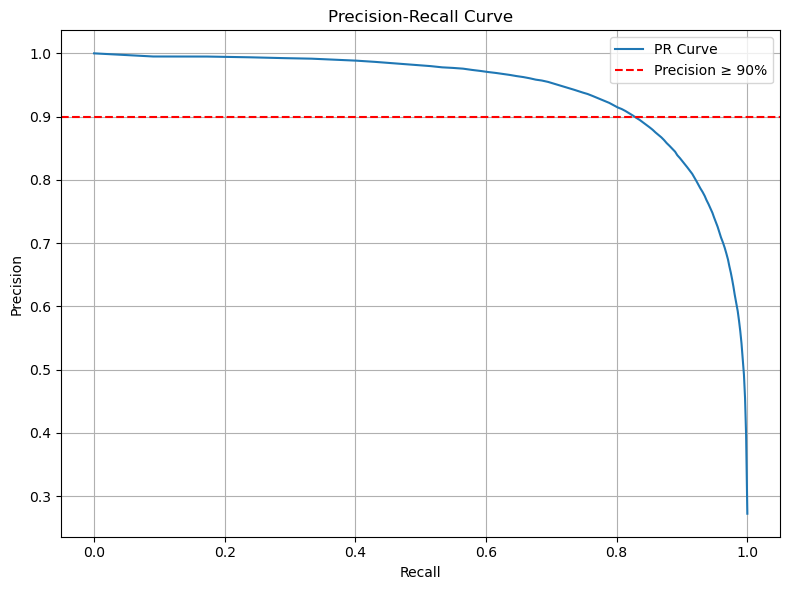

In [31]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve


# Specify target and predicted label probabilities
y_true = y.copy()
y_proba = results['Engineered'].copy()

# 1. Maximize Youden’s J statistic
fpr, tpr, thresholds = roc_curve(y, y_proba)
youden_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_index]
print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")

# 2. Minimize distance to (0,1) on the ROC curve
distances = np.sqrt((1 - tpr)**2 + fpr**2)
best_idx = np.argmin(distances)
optimal_threshold = thresholds[best_idx]
print(f'Optimal threshold (closest to (0,1)): {optimal_threshold:.3f}')

# 3. Precision-based threshold
desired_precision = 0.9
precision, recall, thresholds = precision_recall_curve(y, y_proba)
idx = np.argmax(precision >= desired_precision)
optimal_threshold = thresholds[idx] if idx < len(thresholds) else 1.0
print(f'Optimal threshold (≥{desired_precision:.0%} precision): {optimal_threshold:.3f}')

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.axhline(desired_precision, color='red', linestyle='--', label=f'Precision ≥ {desired_precision:.0%}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We will not use **Youden's J** because it assumes symmetric costs (which we do not have). Nor will we use the point **closest to (0, 1)** because it is good for ranking and also is not good for thresholding under asymmetry. The **precision-based threshold** directly aligns with our objective of minimizing false positives.  

Due to our assumption of asymmetric costs and our goal of maximizing precision (because false positives are costly), we will continue with the optimal threshold from method #3 of 0.546.

In [32]:
OPTIMAL_THRESHOLD = 0.546

In [33]:
# Rerun the model evaluation using the best features and optimal threshold
final_model, _, y_proba_best = evaluate_model_with_cv(
    df=df_best,
    label_col=ML_TARGET,
    drop_cols=drop_cols,
    model=BASE_RF,
    cv=cv,
    seed=SEED,
    threshold=OPTIMAL_THRESHOLD,
)

# Store the best model from feature engineering
results['Engineered'] = y_proba_best

=== Classification Report (Cross-Validated) ===
              precision    recall  f1-score   support

Below Target       0.94      0.97      0.95    118265
Above Target       0.90      0.82      0.86     44270

    accuracy                           0.93    162535
   macro avg       0.92      0.90      0.91    162535
weighted avg       0.93      0.93      0.93    162535

Precision (Above Target): 0.902
Average Precision Score (PR AUC): 0.941
Area Under the ROC Curve (ROC AUC): 0.975


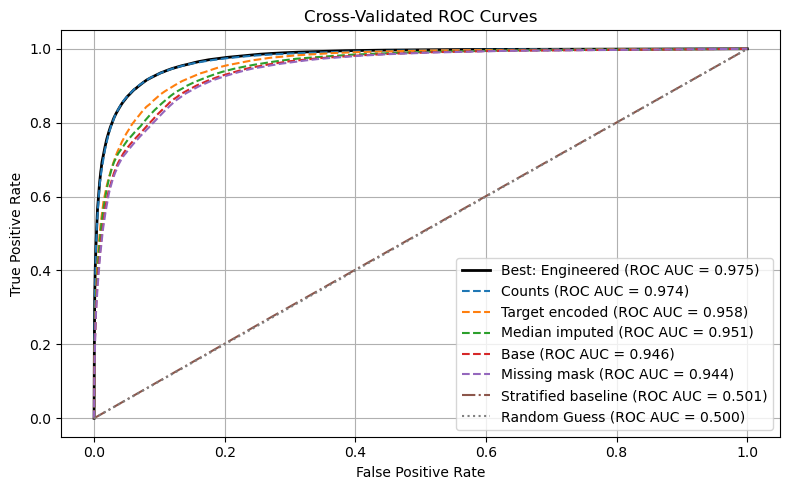

In [34]:
# Create ROC curves for all trained models, the baseline RF model, and the stratified baseline
create_roc_curves(y, results, save_figure=SAVE_DATA, save_name='cross_validated_roc_curves.png')

### Inference

Now, let us re-use the model which was trained on the entire dataset using the best set of features and determine the highly-important features. This will allow us to have additional insight into the factors which have the largest individual influence on whether or not the median income 1 year after exceeds the pre-defined threshold.

In [35]:
# Train final model on full best-feature dataset
X = df_best.drop(columns=drop_cols + [ML_TARGET], errors='ignore')
y = df_best[ML_TARGET]
final_model.fit(X, y);

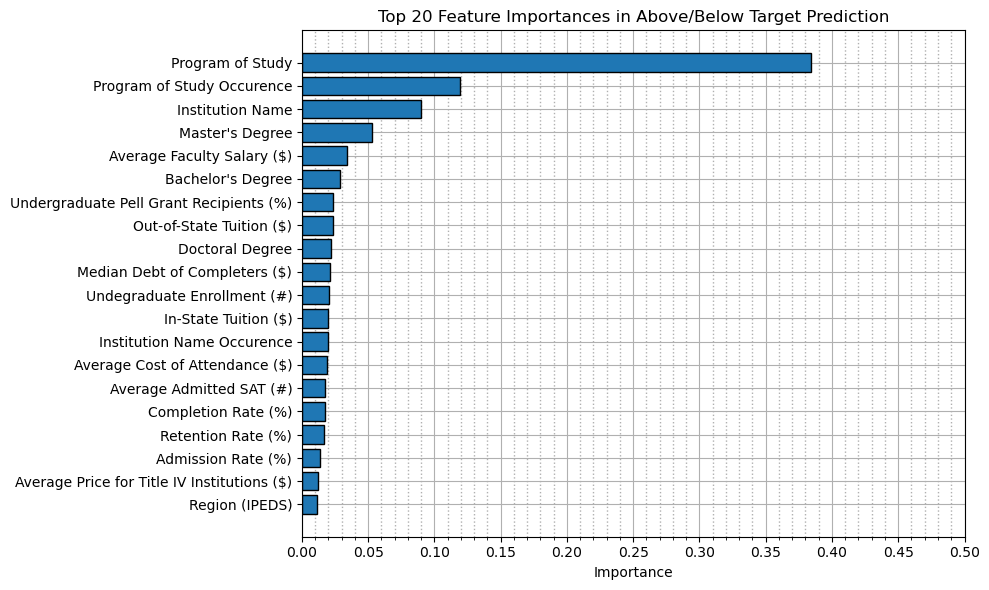

In [36]:
import matplotlib.ticker as ticker


def clean_feature_name(name):
    # Remove preprocessing prefixes
    name = name.replace("num__", "").replace("remainder__", "")
    
    # Strip engineered suffixes
    # for suffix in ['_imputed', '_freq', '_encoded']:
    for suffix in ['_imputed', '_encoded']:
        name = name.replace(suffix, '')
    
    # Modify the frequency-encoding suffix
    if '_freq' in name:
        if 'UNITID' in name:
            name = 'Institution Name Occurence'
        if 'CIPCODE' in name:
            name = 'Program of Study Occurence'

    return name


FEATURE_NAME_MAP = {
    'CIPCODE': 'Program of Study',
    'UNITID': 'Institution Name',
    'CREDLEV_5': "Master's Degree",
    'AVGFACSAL': 'Average Faculty Salary ($)',
    'CREDLEV_3': "Bachelor's Degree",
    'PCTPELL': 'Undergraduate Pell Grant Recipients (%)',
    'TUITIONFEE_OUT': 'Out-of-State Tuition ($)',
    'CREDLEV_6': "Doctoral Degree",
    'GRAD_DEBT_MDN_SUPP': 'Median Debt of Completers ($)',
    'UGDS': 'Undegraduate Enrollment (#)',
    'TUITIONFEE_IN': 'In-State Tuition ($)',
    'COSTT4_A': 'Average Cost of Attendance ($)',
    'SAT_AVG': 'Average Admitted SAT (#)',
    'C150_4': 'Completion Rate (%)',
    'RET_FT4': 'Retention Rate (%)',
    'ADM_RATE': 'Admission Rate (%)',
    'NPT4_PUB': 'Average Price for Title IV Institutions ($)',
    'REGION': 'Region (IPEDS)',
}


# Compute feature feature importances
model = final_model.named_steps['clf']
processed_feature_names = final_model.named_steps['preprocessor'].get_feature_names_out(X.columns)

# Create cleaned names
cleaned_names = [clean_feature_name(name) for name in processed_feature_names]

# Take top N important features
top_n = 20
importances = pd.Series(model.feature_importances_, index=cleaned_names).sort_values(ascending=False).head(top_n)
top_features = importances.head(top_n)

# Map to interpretable labels for plotting
labels_for_plot = [FEATURE_NAME_MAP.get(name, name) for name in top_features.index]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.barh(labels_for_plot, top_features.values, ec='k')

# Major and minor ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))  # labeled ticks every 0.05
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))  # tick marks every 0.01

# Grid settings
ax.grid(True, which='major')
ax.grid(True, which='minor', linestyle=':', linewidth=1.0, alpha=1)
ax.set_axisbelow(True)

ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Feature Importances in Above/Below Target Prediction')
ax.set_xlim(0, 0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Save the figure
if SAVE_DATA:
    fig.savefig("feature_importance_plot.png", dpi=500, bbox_inches="tight", transparent=False)

In [37]:
# Determine the relative importance of the program of study to the institution itself
cipcode_unitid_relative_importance = importances['CIPCODE'] / importances['UNITID']
print(f'The CIPCODE feature (program of study) is about {cipcode_unitid_relative_importance:.2f} times more important to the model than the UNITID feature (institution identity), according to the Random Fores\'ts feature imporance scores.')

The CIPCODE feature (program of study) is about 4.26 times more important to the model than the UNITID feature (institution identity), according to the Random Fores'ts feature imporance scores.


This feature importance plot highlights that the most influential factor in predicting whether a postsecondary program leads to earnings above the target threshold is the **program of study** itself, with `CIPCODE_encoded` (Program of Study) and `CIPCODE_freq` (Program of Study Occurence) ranking highest and significantly higher than other features. Another way to look at it is that in this model, the choice of major has over **four times (4.26)** the predictive power of the choice of institution or any non-program related feature in determining whether an institution-program leads to above-threshold income. This suggests that the choice of major plays a dominant role in post-graduation income outcomes. The **institutional identity** (`UNITID_encoded`) still is a major contributor, reinforcing that where a student studies can significantly impact financial results.  

Credential level also meaningfully affects predicted earnings, with `CREDLEV_5` (Master's degree') among the top features suggesting that graduate credentials strongly increase the likelihood of earning above the target threshold. Both `CREDLEV_3` (Bachelor's degree) and `CREDLEV_6` (Doctoral degree) are present but rank lower. This implies a more limited or variable impact from these factors.

As a reminder:  
1. My sister-in-law's top schools of interest are **James Madison University**, **Towson University**, **University of Maryland College Park**, and **West Virginia University**.  
2. She is more interested in traditional liberal arts degrees like **English**, **history**, **political science**, **psychology**, and **sociology**.

To start, we will determine all `UNITID`s corresponding to the schools of interest as they are the identifying information from the institution used to train the model.

In [38]:
# Specify the schools of interest
SCHOOLS_OF_INTEREST = [
    'James Madison University',
    'Towson University',
    'University of Maryland-College Park',
    'West Virginia University',
]

# Specify the program(s) of interest
PROGRAMS_OF_INTEREST = [
    'English',
    'History',
    'Political science',
    'Psychology',
    'Sociology',
]

# Filter rows corresponding to schools of interest
matched_rows = institution_df[institution_df['INSTNM'].isin(SCHOOLS_OF_INTEREST)]

# Check that each name maps to exactly one UNITID
grouped = matched_rows.groupby('INSTNM')['UNITID'].nunique()

# Print any problematic names (those mapping to more than one UNITID)
ambiguous = grouped[grouped > 1]
if not ambiguous.empty:
    raise ValueError(f'The following institution names map to multiple UNITIDs: {ambiguous}.')

# Extract the mapping from school name to UNITID
name_to_unitid = matched_rows.drop_duplicates(subset=['INSTNM'])[['INSTNM', 'UNITID']].set_index('INSTNM')['UNITID']

Great! All institution names map to a single unique `UNITID`. Next we need to determine all programs at each institution which may be associated with the programs of interest.

In [39]:
import re


# Case-insensitive pattern for programs of interest
pattern = '|'.join(PROGRAMS_OF_INTEREST)

# Get all rows where UNITID is in the mapping and CIPDESC matches a program of interest
unitids = name_to_unitid.values
mask = field_df['CIPDESC'].str.contains(pattern, flags=re.IGNORECASE, na=False)

# Filter and get distinct UNITID–CIPCODE pairs
cipcode_subset = field_df[
    field_df['UNITID'].isin(unitids) & mask
][['UNITID', 'CIPCODE']].drop_duplicates()

# Group by UNITID to get list of CIPCODEs per institution
unitid_to_cipcodes = cipcode_subset.groupby('UNITID')['CIPCODE'].unique()

# Create pairs for each UNITID + CIPCODE
unitid_cipcode_pairs = [
    {'UNITID': int(uid), 'CIPCODE': cip}
    for uid, cip_list in unitid_to_cipcodes.items()
    for cip in cip_list
]
df_pairs = pd.DataFrame(unitid_cipcode_pairs)

For simplicity, we will assume that each institution's key characteristics (e.g., tuition fees, admission rates, average faculty salary, etc.) remain relatively stable across the years of interest. While this approach may introduce some temporal approximation error, it allows us to summarize each institution using a single representative profile.  

To improve prediction accuracy in the future, we could use more time-specific institution-level data at the point of student admission - either from external research or separate predictive modeling. That being said, next we will compute the average values of relevant features per institution (`UNITID`), excluding encoded and frequency-engineered features. We also fill in each institution's `REGION` using the most commonly observed values.

In [40]:
# Identify variables to average, excluding engineered features
vars_to_average = []

# Include base columns that were imputed
vars_to_average += [col.replace('_imputed', '') for col in X.columns if col.endswith('_imputed')]

# Include all other raw columns that are not engineered
vars_to_average += [
    col for col in X.columns 
    if not col.endswith(('_encoded', '_freq', '_imputed')) and col not in vars_to_average
]

# Filter and group by UNITID, then take the mean
unitids_of_interest = name_to_unitid[SCHOOLS_OF_INTEREST].values
grouped_avg = (
    df_clean[df_clean['UNITID'].isin(unitids_of_interest)]
    .groupby('UNITID')[vars_to_average]
    .mean(numeric_only=True)
)
grouped_avg = grouped_avg.reset_index()

# Fill REGION per UNITID using mode if available
region_mode = (
    df_clean[df_clean['UNITID'].isin(unitids_of_interest)]
    .groupby('UNITID')['REGION']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
)

# Assign REGION back into the grouped average
grouped_avg['REGION'] = grouped_avg['UNITID'].map(region_mode)

As a reminder, my sister-in-law is primarily interested in earning a Bachelor's Degree (`CREDLEV` = 3). We will create a prediction dataset assuming the credential level of 3.

In [41]:
def create_prediction_dataset(grouped_avg, df_clean, df_pairs, field_df, ml_target, name_to_unitid, credlev_value=3):
    pred_df = grouped_avg.copy()

    # Specify that the level of credential is a Bachelor's Degree
    credlev_ohe_cols = [col for col in pred_df.columns if col.startswith('CREDLEV_')]

    # Set all CREDLEV_* columns to 0
    pred_df.loc[:, credlev_ohe_cols] = 0

    # Set the desired CREDLEV column to 1
    target_col = f'CREDLEV_{credlev_value}'
    if target_col in pred_df.columns:
        pred_df.loc[:, target_col] = 1
    else:
        raise ValueError(f"{target_col} not found in DataFrame columns.")

    # Combine the UNITID/CIPCODE and the prediction data
    pred_df = df_pairs.merge(pred_df, on='UNITID', how='left')

    # Compute count/frequency encoded features based off of appearance in the training data
    unitid_freq = df_clean['UNITID'].value_counts().to_dict()
    cipcode_freq = df_clean['CIPCODE'].value_counts().to_dict()
    pred_df['UNITID_freq'] = pred_df['UNITID'].map(unitid_freq).fillna(0)
    pred_df['CIPCODE_freq'] = pred_df['CIPCODE'].map(cipcode_freq).fillna(0)

    # Median impute numeric columns based on the training data
    numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
    medians = df_clean[numeric_cols].median(numeric_only=True).to_dict()
    new_cols = []
    for col in numeric_cols:
        if col in pred_df.columns and col not in ['UNITID', 'CIPCODE']:
            pred_df[f'{col}_imputed'] = pred_df[col].fillna(medians[col])
            pred_df.drop(columns=col, inplace=True)

    # Compute target encoded features based on out-of-fold strategy during training
    unitid_target_mean = df_clean.groupby('UNITID')[ml_target].mean().to_dict()
    cipcode_target_mean = df_clean.groupby('CIPCODE')[ml_target].mean().to_dict()
    pred_df['UNITID_encoded'] = pred_df['UNITID'].map(unitid_target_mean).fillna(0)
    pred_df['CIPCODE_encoded'] = pred_df['CIPCODE'].map(cipcode_target_mean).fillna(0)

    # Map UNITID to institution name
    unitid_to_name = name_to_unitid.to_dict()
    name_lookup = {v: k for k, v in unitid_to_name.items()}  # Reverse the mapping
    pred_df['INSTNM'] = pred_df['UNITID'].map(name_lookup)

    # Map CIPCODE to description
    cipcode_to_desc = (
        field_df[['CIPCODE', 'CIPDESC']]
        .drop_duplicates()
        .set_index('CIPCODE')['CIPDESC']
        .to_dict()
    )
    pred_df['CIPDESC'] = pred_df['CIPCODE'].map(cipcode_to_desc)

    return pred_df


# Create prediction dataset for a credential level of a Bachelor's Degree (3)
pred_df = create_prediction_dataset(grouped_avg, df_clean, df_pairs, field_df, ML_TARGET, name_to_unitid, credlev_value=3)

Now using our optimal threshold from before (0.546), we can predict which institution + program combinations from my sister-in-law's schools and programs of interest would have a Bachelor's degree earning more than $50,000 1 year after graduation.

In [42]:
# Predict probabilities
pred_df['probability'] = final_model.predict_proba(pred_df)[:, 1]

# Add binary prediction based on threshold
pred_df['is_above_income_threshold'] = (pred_df['probability'] >= OPTIMAL_THRESHOLD).astype(bool)

# Display final results
pred_df[['INSTNM', 'CIPDESC', 'probability', 'is_above_income_threshold']].sort_values(by='probability', ascending=False).reset_index(drop=True)

,INSTNM,CIPDESC,probability,is_above_income_threshold
0,James Madison University,"Clinical, Counseling and Applied Psychology.",0.44,False
1,University of Maryland-College Park,"Clinical, Counseling and Applied Psychology.",0.43,False
2,University of Maryland-College Park,"Psychology, Other.",0.24,False
3,Towson University,"Clinical, Counseling and Applied Psychology.",0.18,False
4,West Virginia University,"Clinical, Counseling and Applied Psychology.",0.15,False
5,James Madison University,Research and Experimental Psychology.,0.06,False
6,University of Maryland-College Park,Research and Experimental Psychology.,0.04,False
7,University of Maryland-College Park,"English Language and Literature, General.",0.01,False
8,University of Maryland-College Park,Political Science and Government.,0.01,False
9,West Virginia University,Sociology.,0.01,False


Unfortunately, **none of the institution-program pairs** have a probability above the chosen optimal threshold of 0.546. Of the pairs, the **Clinical, Counseling and Applied Psychology** program at either **James Madison University** or **University of Maryland College Park** come the closest at 0.44 and 0.43, respectively.  

Just for completeness, let's reevaluate the pairs considering a Master's Degree (`CREDLEV` = 5).

In [43]:
# Create prediction dataset for a credential level of a Master's Degree (5)
pred_df_masters = create_prediction_dataset(grouped_avg, df_clean, df_pairs, field_df, ML_TARGET, name_to_unitid, credlev_value=5)

# Predict probabilities
pred_df_masters['probability'] = final_model.predict_proba(pred_df_masters)[:, 1]

# Add binary prediction based on threshold
pred_df_masters['is_above_income_threshold'] = (pred_df_masters['probability'] >= OPTIMAL_THRESHOLD).astype(bool)

# Display final results
pred_df_masters[['INSTNM', 'CIPDESC', 'probability', 'is_above_income_threshold']].sort_values(by='probability', ascending=False).reset_index(drop=True)

,INSTNM,CIPDESC,probability,is_above_income_threshold
0,University of Maryland-College Park,"Clinical, Counseling and Applied Psychology.",0.89,True
1,University of Maryland-College Park,"Psychology, Other.",0.88,True
2,University of Maryland-College Park,Research and Experimental Psychology.,0.66,True
3,Towson University,"Clinical, Counseling and Applied Psychology.",0.57,True
4,University of Maryland-College Park,"Psychology, General.",0.52,False
5,University of Maryland-College Park,"English Language and Literature, General.",0.46,False
6,West Virginia University,"Clinical, Counseling and Applied Psychology.",0.41,False
7,James Madison University,"Clinical, Counseling and Applied Psychology.",0.38,False
8,University of Maryland-College Park,History.,0.34,False
9,University of Maryland-College Park,Political Science and Government.,0.34,False


If the received credential level is a **Master's Degree**, **multiple programs** at the **University of Maryland College Park** and the **Clinical, Counseling and Applied Psychology** program at **Towson University** predict earning above the income threshold.

# Conclusion

In this analysis, we developed a machine learning model to predict whether a given postsecondary program at a specific institution is likely to result in earnings above a defined income threshold. Our objective was to identify which college–major combinations might help my sister-in-law reach her financial goal of earning at least $50,000 within a year of completing her degree. The analysis focused on her preferred liberal arts fields (e.g., English, history, political science, psychology, and sociology) and her shortlist of schools: James Madison University, Towson University, University of Maryland College Park, and West Virginia University.  

In this model, the **choice of major** has the highest predictive power by far, with over **four times (4.26)** the predictive power of the choice of institution or any non-program related feature in determining whether an institution-program leads to above-threshold income.  The **institution itself** and **credential level** also contribute significant predictive power.

When considering only Bachelor's degrees, none of the institution-program pairs in her areas of interest surpassed the income threshold of $50,000. However, the **Clinical, Counseling, and Applied Psychology** program at **James Madison University** and **University of Maryland College Park** came the closest, suggesting that with a Bachelor’s-level credential, certain applied fields within the liberal arts may be acceptable. Reevaluating the same programs under the assumption that she earns a **Master’s Degree** changes the outlook considerably. With this higher credential level, **multiple graduate programs in Psychology at the University of Maryland College Park** and the **Clinical, Counseling and Applied Psychology** program at **Towson University** are predicted to exceed the income threshold, indicating that continued education may substantially improve her earning potential - especially within the field of psychology.

Overall my recommendations to my sister-in-law will be:  
1. Broaden school options and explore other majors if only interested in pursuing a Bachelor's while keeping the income requirement.
2. Consider a Master's to meet income requirements if keeping current schools and majors.  
3. Prioritize University of Maryland College Park and (if pursuing a Master's) Towson University among current choices.
4. Use the predicted results as a decision support tool, not a final answer.

Thanks for following along, and I hope that you learned something!